### AWS 다이어그램 객체 탐지 실험

- 작성일자: 2025-08-07
- 작성자: 우성민 <sungminwoo.devops@gmail.com>

#### 설정

In [2]:
# 환경변수 설정
import os
from dotenv import load_dotenv
load_dotenv()
ROBOFLOW_API_KEY = os.getenv('ROBOFLOW_API_KEY', "GmmcPzjqUM0s4fqtIu1V")

In [3]:
# 표준 라이브러리
import gc
import json
import shutil
from datetime import datetime
from io import BytesIO
from pathlib import Path
from typing import Dict, List, Tuple
from collections import Counter
from glob import glob

# 외부 라이브러리 - 데이터 처리 및 시각화
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# 외부 라이브러리 - 이미지 처리 및 증강
import cv2
import albumentations as A

# 외부 라이브러리 - 딥러닝 및 모델
import tensorflow as tf
from ultralytics import YOLO

# 외부 라이브러리 - 기타 유틸
import requests
import yaml
from roboflow import Roboflow

# 외부 라이브러리 - 모델 학습 유틸
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
# 현재 프로젝트 디렉터리 확인
print(os.getcwd())

/home/smallpod/workspace/hit_aws_object_detection


In [5]:
# GPU 설정
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    tf.config.set_visible_devices(tf.config.list_physical_devices('CPU')[0], 'CPU')

### EDA

In [6]:
# Roboflow 데이터 다운로드
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("aws-icons").project("aws-icon-detector")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


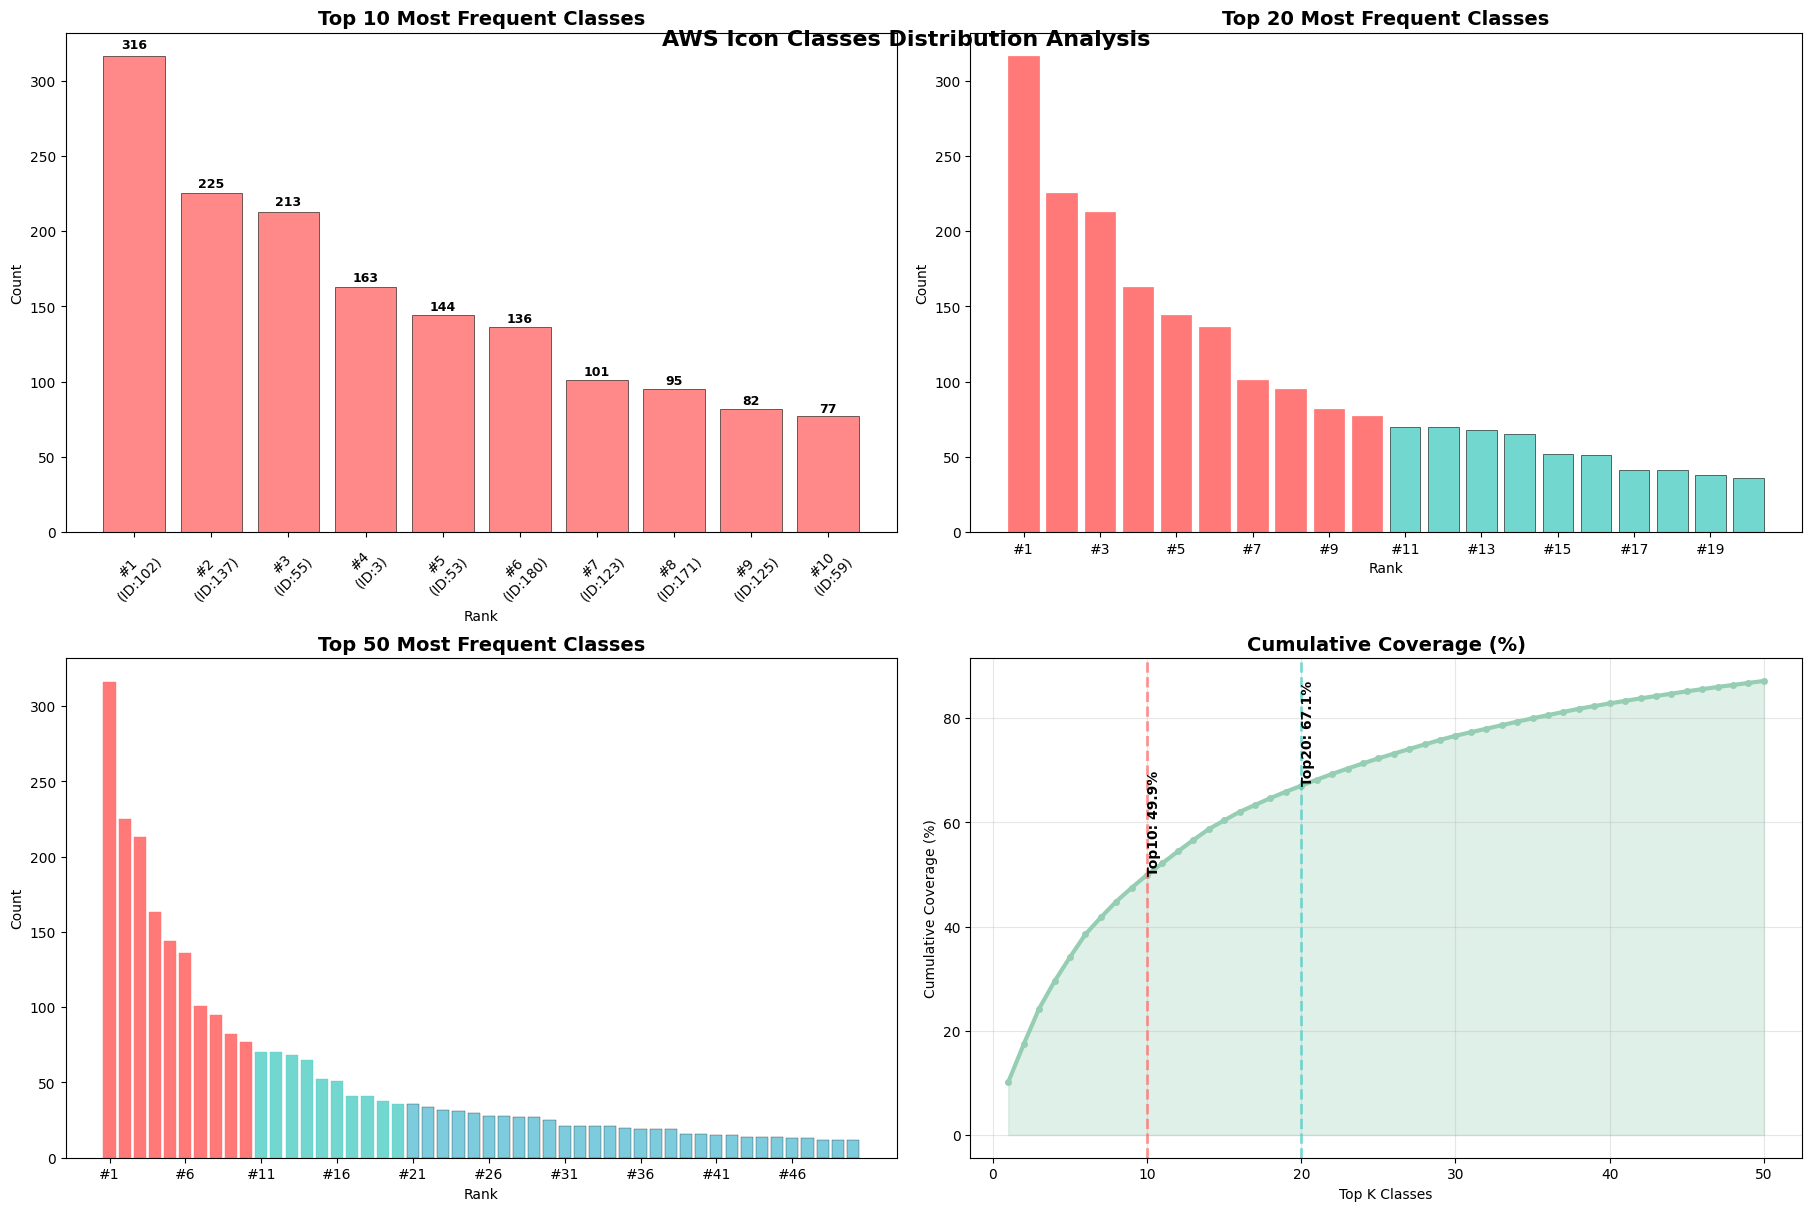

📊 데이터 분포 요약:
   • 전체 클래스 수: 182
   • 전체 샘플 수: 3,108
   • Top 10 커버리지: 49.9%
   • Top 20 커버리지: 67.1%
   • Top 50 커버리지: 87.2%


<Figure size 640x480 with 0 Axes>

In [ ]:
# 라벨 경로
label_dir = "AWS-Icon-Detector--4/train/labels"
labels = glob(f"{label_dir}/*.txt")
class_counts = Counter()

# 클래스별 개수 집계
for path in labels:
    with open(path) as f:
        for line in f:
            class_id = int(line.strip().split()[0])
            class_counts[class_id] += 1

# 전체 클래스 수 (0부터 시작한다고 가정)
num_classes = max(class_counts.keys()) + 1
counts = [class_counts.get(i, 0) for i in range(num_classes)]



# 클래스 정렬 함수
def get_sorted_counts(top_k=None):
    sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    if top_k:
        sorted_items = sorted_items[:top_k]
    class_ids, values = zip(*sorted_items)
    return class_ids, values

# 정렬된 전체 분포
sorted_ids_all, sorted_vals_all = get_sorted_counts()

# Top-K
top10_ids, top10_vals = get_sorted_counts(10)
top20_ids, top20_vals = get_sorted_counts(20)
top50_ids, top50_vals = get_sorted_counts(50)


# 1. 서브플롯으로 Top10/20/50 비교
fig, axs = plt.subplots(2, 2, figsize=(18, 12), constrained_layout=True)

# Top 10 (왼쪽 상단)
bars1 = axs[0, 0].bar(range(len(top10_ids)), top10_vals, color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=0.5)
axs[0, 0].set_title("Top 10 Most Frequent Classes", fontsize=14, fontweight='bold')
axs[0, 0].set_xlabel("Rank")
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_xticks(range(len(top10_ids)))
axs[0, 0].set_xticklabels([f"#{i+1}\n(ID:{cls_id})" for i, cls_id in enumerate(top10_ids)], rotation=45)
# 값 표시
for i, (bar, val) in enumerate(zip(bars1, top10_vals)):
    axs[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + val*0.01, 
                   str(val), ha='center', va='bottom', fontweight='bold', fontsize=9)

# Top 20 (오른쪽 상단)
bars2 = axs[0, 1].bar(range(len(top20_ids)), top20_vals, color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=0.5)
axs[0, 1].set_title("Top 20 Most Frequent Classes", fontsize=14, fontweight='bold')
axs[0, 1].set_xlabel("Rank")
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_xticks(range(0, len(top20_ids), 2))  # 2개씩 건너뛰어 표시
axs[0, 1].set_xticklabels([f"#{i+1}" for i in range(0, len(top20_ids), 2)])
# Top 10은 빨간색으로 강조
for i, bar in enumerate(bars2):
    if i < 10:
        bar.set_color('#FF6B6B')
        bar.set_alpha(0.9)

# Top 50 (왼쪽 하단)
bars3 = axs[1, 0].bar(range(len(top50_ids)), top50_vals, color='#45B7D1', alpha=0.7, edgecolor='black', linewidth=0.3)
axs[1, 0].set_title("Top 50 Most Frequent Classes", fontsize=14, fontweight='bold')
axs[1, 0].set_xlabel("Rank")
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_xticks(range(0, len(top50_ids), 5))  # 5개씩 건너뛰어 표시
axs[1, 0].set_xticklabels([f"#{i+1}" for i in range(0, len(top50_ids), 5)])
# Top 10, 20 구간별 색상 구분
for i, bar in enumerate(bars3):
    if i < 10:
        bar.set_color('#FF6B6B')  # Top 10
        bar.set_alpha(0.9)
    elif i < 20:
        bar.set_color('#4ECDC4')  # Top 11-20
        bar.set_alpha(0.8)

# 누적 비율 (오른쪽 하단)
cumulative_counts = np.cumsum(top50_vals)
total_count = sum(class_counts.values())
cumulative_ratio = (cumulative_counts / total_count) * 100

axs[1, 1].plot(range(1, len(top50_ids)+1), cumulative_ratio, marker='o', linewidth=3, markersize=4, color='#96CEB4')
axs[1, 1].fill_between(range(1, len(top50_ids)+1), cumulative_ratio, alpha=0.3, color='#96CEB4')
axs[1, 1].set_title("Cumulative Coverage (%)", fontsize=14, fontweight='bold')
axs[1, 1].set_xlabel("Top K Classes")
axs[1, 1].set_ylabel("Cumulative Coverage (%)")
axs[1, 1].grid(True, alpha=0.3)

# 중요한 지점 표시
axs[1, 1].axvline(x=10, color='#FF6B6B', linestyle='--', alpha=0.7, linewidth=2)
axs[1, 1].axvline(x=20, color='#4ECDC4', linestyle='--', alpha=0.7, linewidth=2)
axs[1, 1].text(10, cumulative_ratio[9], f'Top10: {cumulative_ratio[9]:.1f}%', 
               rotation=90, verticalalignment='bottom', fontweight='bold')
axs[1, 1].text(20, cumulative_ratio[19], f'Top20: {cumulative_ratio[19]:.1f}%', 
               rotation=90, verticalalignment='bottom', fontweight='bold')

plt.suptitle('AWS Icon Classes Distribution Analysis', fontsize=16, fontweight='bold', y=0.98)
plt.show()

print(f"📊 데이터 분포 요약:")
print(f"   • 전체 클래스 수: {num_classes}")
print(f"   • 전체 샘플 수: {total_count:,}")
print(f"   • Top 10 커버리지: {cumulative_ratio[9]:.1f}%")
print(f"   • Top 20 커버리지: {cumulative_ratio[19]:.1f}%")
print(f"   • Top 50 커버리지: {cumulative_ratio[49]:.1f}%")


plt.savefig('./output/class_distribution.png')

In [14]:
# 라벨 파일 경로
label_files = glob("AWS-Icon-Detector--4/train/labels/*.txt")

# 클래스별 등장 횟수 집계
class_counts = Counter()
for file in label_files:
    with open(file) as f:
        for line in f:
            class_id = int(line.strip().split()[0])
            class_counts[class_id] += 1

# 전체 등장 횟수
total_count = sum(class_counts.values())

# 클래스 등장 순으로 정렬
sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Top 10 / 20 / 50 추출
top10 = sorted_items[:10]
top20 = sorted_items[:20]
top50 = sorted_items[:50]

# 분리
top10_ids, top10_vals = zip(*top10)
top20_ids, top20_vals = zip(*top20)
top50_ids, top50_vals = zip(*top50)


In [19]:
import yaml
from pprint import pprint

with open("AWS-Icon-Detector--4/data.yaml", 'r') as f:
    data = yaml.safe_load(f)
    class_names = data['names']

# 등장하지 않은 클래스
unseen_classes = [i for i in range(num_classes) if i not in class_counts]
unseen_class_names = [class_names[i] for i in unseen_classes]
pprint(f"📊 등장하지 않은 클래스: {unseen_class_names}")


("📊 등장하지 않은 클래스: ['Detective', 'Distribution', 'EMR', 'Elemental "
 "MediaPackage', 'Firewall Manager', 'Flow logs', 'Glacier', 'Inspector "
 "Agent', 'Network Firewall', 'SSM Agent', 'Sign-On', 'Snowball', 'Storage "
 "Gateway']")


In [23]:
# 1. 계단식(Waterfall) 스타일 비교 차트
fig_combined = go.Figure()

# 배경 (Top 50)
fig_combined.add_trace(go.Bar(
    x=list(range(1, 51)),
    y=top50_vals,
    name='Top 50 (전체)',
    marker_color='lightgray',
    opacity=0.4,
    hovertemplate='<b>Rank %{x}</b><br>Class ID: %{customdata}<br>Count: %{y}<extra></extra>',
    customdata=top50_ids
))

# 중간층 (Top 20)
fig_combined.add_trace(go.Bar(
    x=list(range(1, 21)),
    y=top20_vals,
    name='Top 20',
    marker_color='lightcoral',
    opacity=0.7,
    hovertemplate='<b>Rank %{x}</b><br>Class ID: %{customdata}<br>Count: %{y}<extra></extra>',
    customdata=top20_ids
))

# 최상위 (Top 10)
fig_combined.add_trace(go.Bar(
    x=list(range(1, 11)),
    y=top10_vals,
    name='Top 10',
    marker_color='darkred',
    opacity=0.9,
    hovertemplate='<b>Rank %{x}</b><br>Class ID: %{customdata}<br>Count: %{y}<br><b>Top 10!</b><extra></extra>',
    customdata=top10_ids
))

# 구분선 추가
fig_combined.add_vline(x=10.5, line_dash="dash", line_color="red", 
                      annotation_text="Top 10", annotation_position="top")
fig_combined.add_vline(x=20.5, line_dash="dash", line_color="orange", 
                      annotation_text="Top 20", annotation_position="top")

fig_combined.update_layout(
    title='🎯 Top 10/20/50 Classes 통합 비교',
    xaxis_title='Rank (클래스 순위)',
    yaxis_title='Count (샘플 수)',
    barmode='overlay',  # 오버레이 모드로 겹치기
    height=500,
    width=1000,
    showlegend=True,
    hovermode='x unified'
)

fig_combined.show()

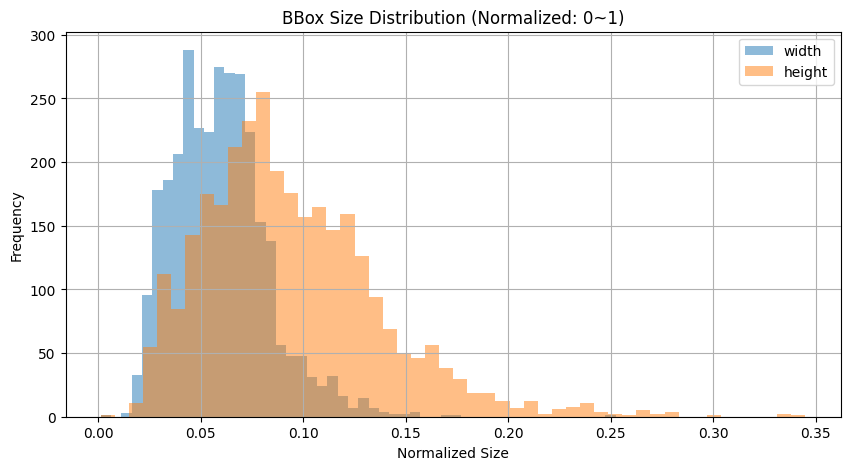

In [26]:
# 1. 라벨 경로 설정
label_dir = "AWS-Icon-Detector--4/train/labels"
label_files = glob(f"{label_dir}/*.txt")

# 2. width, height 값 추출
bbox_wh = []

for file in label_files:
    with open(file) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:  # class_id, x_center, y_center, width, height
                _, _, _, w, h = map(float, parts)
                bbox_wh.append((w, h))

# 3. 분리 및 시각화
if bbox_wh:
    w_vals, h_vals = zip(*bbox_wh)

    plt.figure(figsize=(10, 5))
    plt.hist(w_vals, bins=50, alpha=0.5, label='width')
    plt.hist(h_vals, bins=50, alpha=0.5, label='height')
    plt.xlabel("Normalized Size")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("BBox Size Distribution (Normalized: 0~1)")
    plt.grid(True)
    plt.show()
else:
    print("No bounding boxes found.")


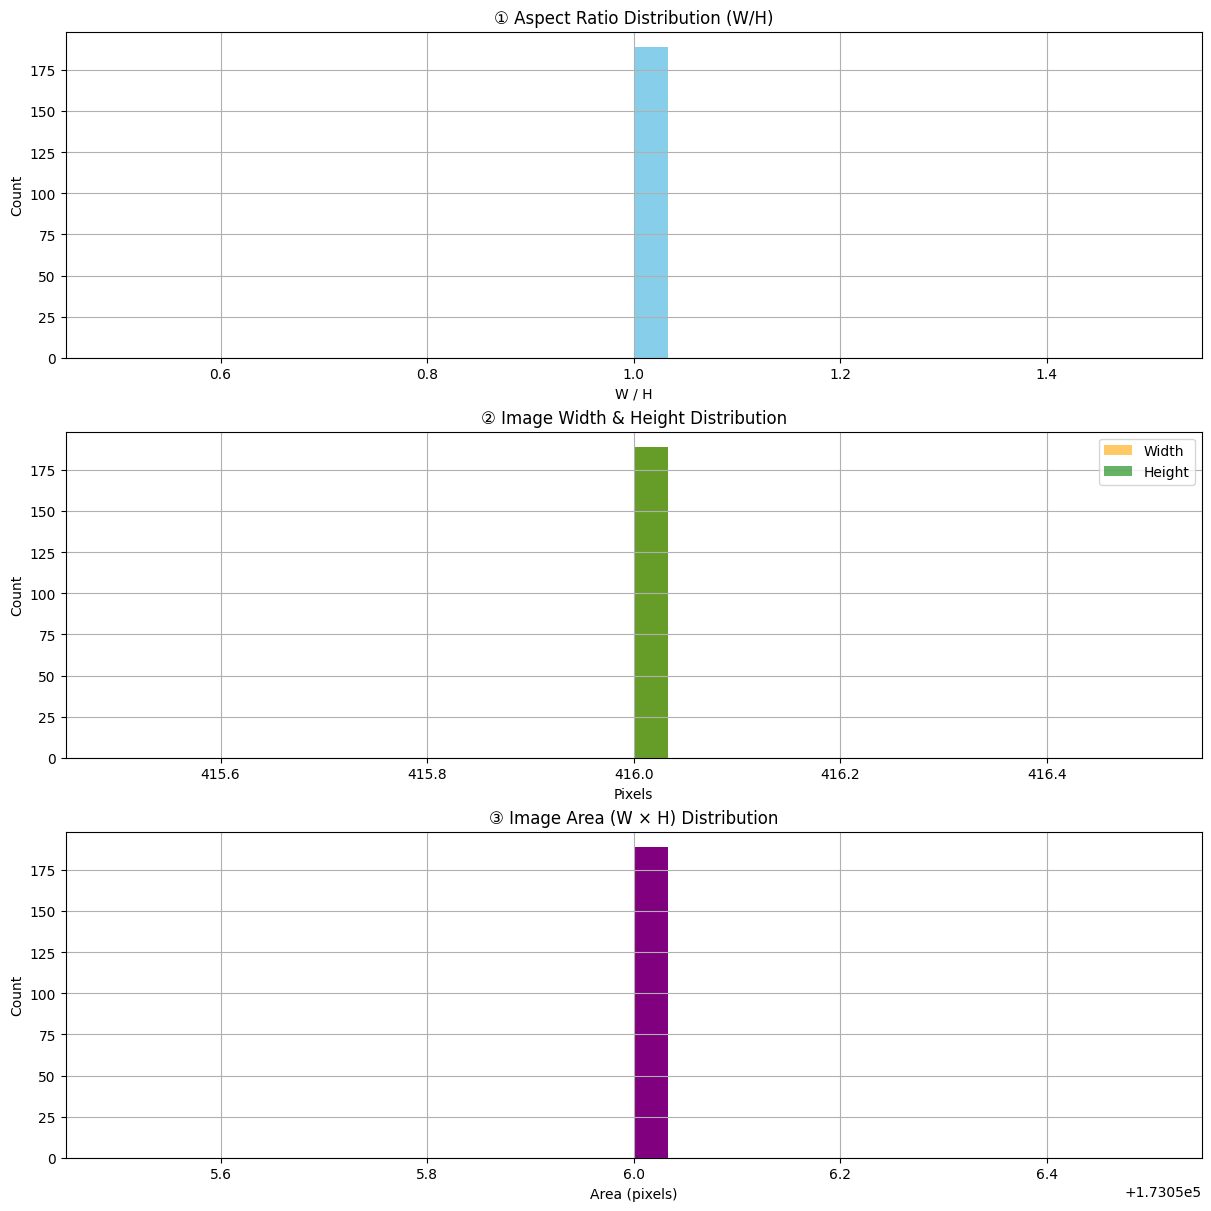

In [ ]:
# 이미지 해상도 및 종횡비 분석

# 이미지 경로 설정
image_dir = "AWS-Icon-Detector--4/train/images"
image_files = glob(f"{image_dir}/*.jpg") + glob(f"{image_dir}/*.png")

# 이미지 크기 수집
shapes = []

for path in image_files:
    img = cv2.imread(path)
    if img is not None:
        h, w = img.shape[:2]
        shapes.append((w, h))

# 분석
if shapes:
    widths, heights = zip(*shapes)
    aspect_ratios = [w/h for w, h in shapes]
    areas = [w * h for w, h in shapes]

    fig, axs = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)

    # 1. Aspect Ratio (W/H)
    axs[0].hist(aspect_ratios, bins=30, color='skyblue')
    axs[0].set_title("Aspect Ratio Distribution (W/H)")
    axs[0].set_xlabel("W / H")
    axs[0].set_ylabel("Count")
    axs[0].grid(True)

    # 2. Width & Height 분포
    axs[1].hist(widths, bins=30, alpha=0.6, label='Width', color='orange')
    axs[1].hist(heights, bins=30, alpha=0.6, label='Height', color='green')
    axs[1].set_title("Image Width & Height Distribution")
    axs[1].set_xlabel("Pixels")
    axs[1].set_ylabel("Count")
    axs[1].legend()
    axs[1].grid(True)

    # 3. Image Area 분포
    axs[2].hist(areas, bins=30, color='purple')
    axs[2].set_title("Image Area (W × H) Distribution")
    axs[2].set_xlabel("Area (pixels)")
    axs[2].set_ylabel("Count")
    axs[2].grid(True)

    plt.show()

else:
    print("No image files found or unreadable.")


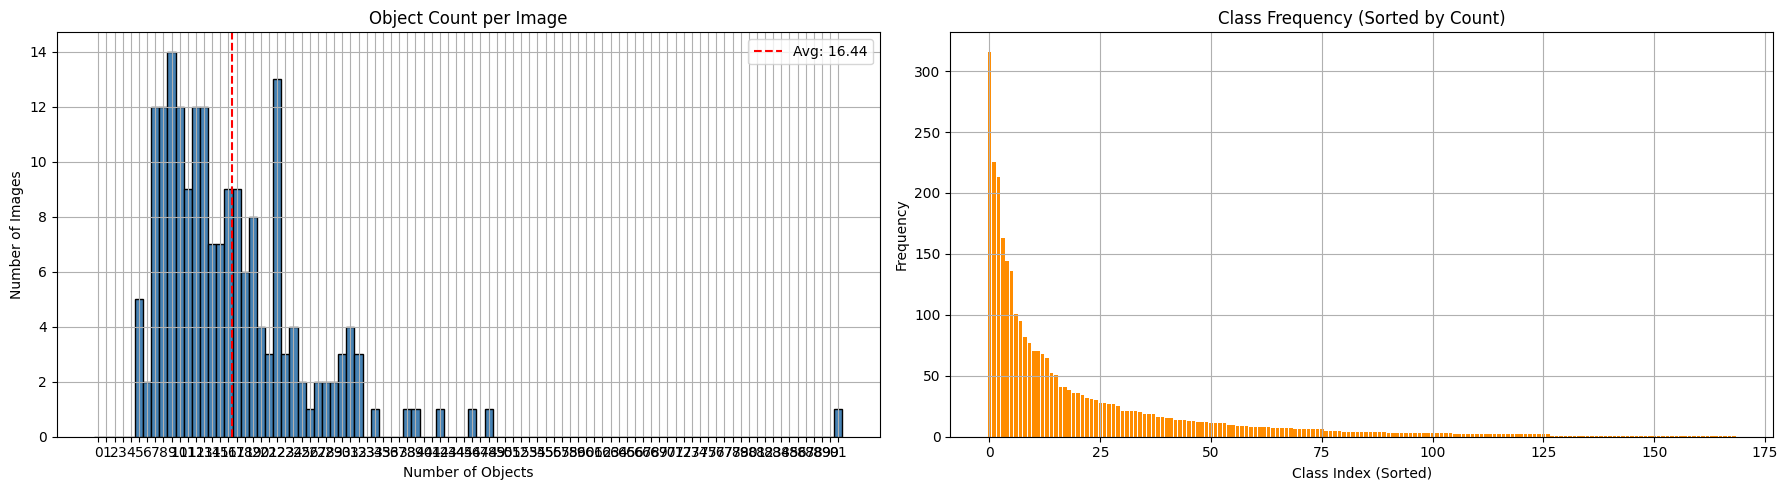

In [27]:
# === [1] 이미지당 객체 수 분포 ===
label_dir = "AWS-Icon-Detector--4/train/labels"
label_files = glob(f"{label_dir}/*.txt")
obj_per_img = [len(open(f).readlines()) for f in label_files]

min_val = min(obj_per_img)
max_val = max(obj_per_img)
avg_val = sum(obj_per_img) / len(obj_per_img)

# === [2] 클래스별 등장 횟수 내림차순 정렬 ===
class_counts = Counter()
for file in label_files:
    with open(file) as f:
        for line in f:
            class_id = int(line.strip().split()[0])
            class_counts[class_id] += 1

sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
class_ids, class_freqs = zip(*sorted_classes)

# === 시각화 (subplot 1행 2열) ===
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# [좌측] 이미지당 객체 수 분포
axs[0].hist(obj_per_img, bins=range(0, max_val + 2), color='steelblue', edgecolor='black', align='left')
axs[0].axvline(avg_val, color='red', linestyle='--', label=f'Avg: {avg_val:.2f}')
axs[0].set_title("Object Count per Image")
axs[0].set_xlabel("Number of Objects")
axs[0].set_ylabel("Number of Images")
axs[0].grid(True)
axs[0].legend()
axs[0].set_xticks(range(0, max_val + 1))

# [우측] 클래스별 등장 빈도 내림차순
axs[1].bar(range(len(class_ids)), class_freqs, color='darkorange')
axs[1].set_title("Class Frequency (Sorted by Count)")
axs[1].set_xlabel("Class Index (Sorted)")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)

plt.tight_layout()
plt.show()


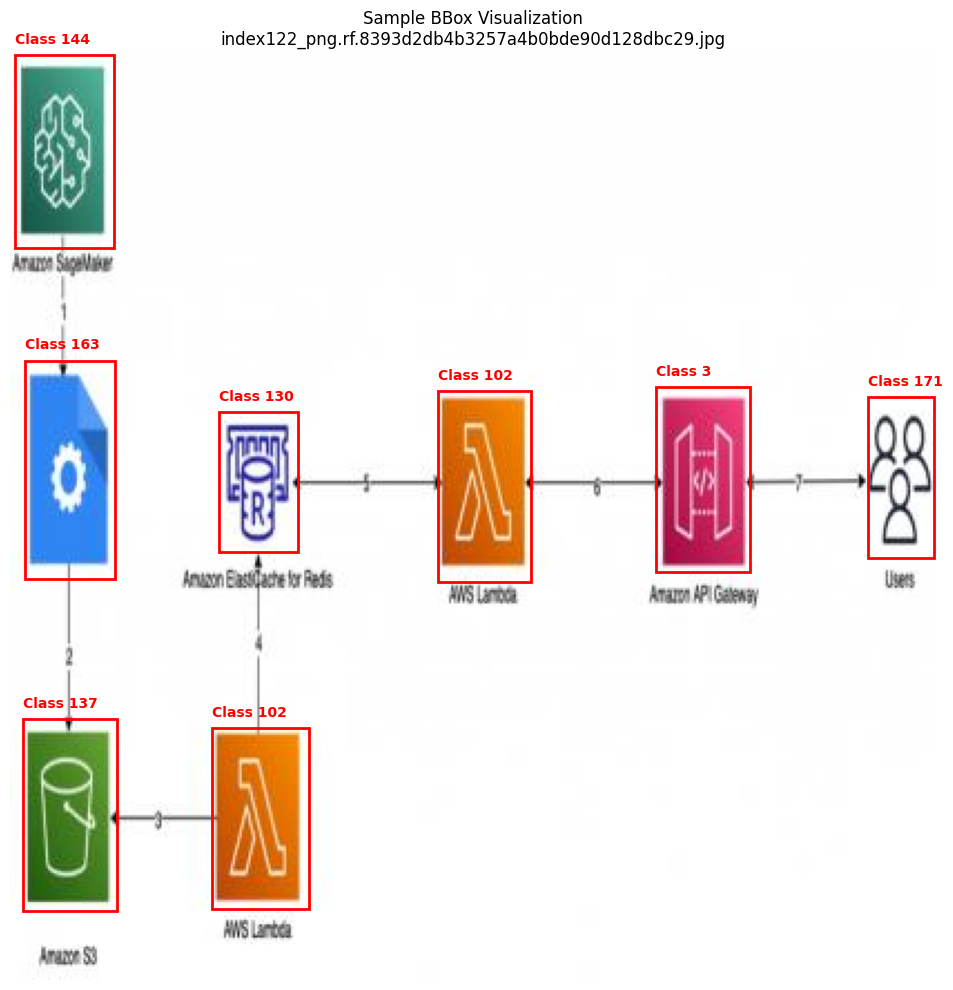

In [21]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
import random
import os

# === 경로 설정 ===
image_dir = "AWS-Icon-Detector--4/train/images"
label_dir = "AWS-Icon-Detector--4/train/labels"

# === 샘플 이미지 자동 선택 ===
image_files = glob(f"{image_dir}/*.jpg") + glob(f"{image_dir}/*.png")
sample_image_path = random.choice(image_files)
sample_label_path = os.path.join(label_dir, os.path.basename(sample_image_path).replace('.jpg', '.txt').replace('.png', '.txt'))

# === 이미지 로드 ===
img = cv2.imread(sample_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# === 시각화 ===
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img)
ax.set_title(f"Sample BBox Visualization\n{os.path.basename(sample_image_path)}")

with open(sample_label_path) as f:
    for line in f:
        parts = list(map(float, line.strip().split()))
        if len(parts) >= 5:
            cls, xc, yc, bw, bh = parts[:5]
            x = (xc - bw / 2) * w
            y = (yc - bh / 2) * h
            bw *= w
            bh *= h
            rect = patches.Rectangle((x, y), bw, bh, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 5, f"Class {int(cls)}", color='red', fontsize=10, weight='bold')

plt.axis("off")
plt.tight_layout()
plt.show()


### 모델 훈련 (YOLOv8)

1. YOLOv5 - 같은 계열, 직접적인 이전 세대 (mAP@50, mAP@50-95, 작은 아이콘 객체 성능)
pip install yolo5

2. YOLO-NAS (SuperGradients) - YOLOv8보다 향상된 성능을 보여주는 최신 YOLO 계열 (mAP 높고 추론 속도 빠름, 쉽게 통합 가능)
pip install super-gradients
from super_gradients.training import models
model = models.get('yolo_nas_s', pretrained=True)

3. EfficientDet-D1


#### yolov8n vs yolov8s

In [ ]:
from ultralytics import YOLO
from datetime import datetime

model_list = ['yolov8n.pt', 'yolov8s.pt']
model_results = {}

for model_name in model_list:
    model = YOLO(model_name)
    
    result = model.train(
        project='/home/smallpod/workspace/hit_aws_object_detection/runs',
        name=model_name.replace('.pt', ''),
        data='/home/smallpod/workspace/hit_aws_object_detection/AWS-Icon-Detector--4/data.yaml',
        workers=4,
        cache='disk',
        epochs=10,
        imgsz=320,
        batch=8,
        patience=10,
        cos_lr=True,
        optimizer='AdamW',
        lr0=0.01,
        lrf=0.1,
        momentum=0.937,
        weight_decay=0.0005,
        warmup_epochs=3.0,
        warmup_momentum=0.8,
        warmup_bias_lr=0.1,
        box=7.5,
        cls=0.5,
        dfl=1.5
    )

    # mAP 추출 (스칼라/리스트 여부 확인)
    map_val = result.box.map
    if isinstance(map_val, (list, tuple)):
        map50 = map_val[0]
        map50_95 = map_val[1]
    else:
        map50 = map_val
        map50_95 = None

    # 성능 저장
    model_results[model_name] = {
        'result': result,
        'mAP50': map50,
        'mAP50-95': map50_95,
    }

    # 저장 경로 확인
    best_model_path = result.save_dir / 'weights' / 'best.pt'
    print(f"{model_name} saved to {best_model_path}")


Ultralytics 8.3.175 🚀 Python-3.10.13 torch-2.8.0+cpu CPU (Cortex-A55)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/home/smallpod/workspace/hit_aws_object_detection/AWS-Icon-Detector--4/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n7, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10, perspective=0

train: Scanning /home/smallpod/workspace/hit_aws_object_detection/AWS-Icon-Detector--4/train/labels.cache... 189 images, 0 backgrounds, 0 corrupt: 100%|██████████| 189/189 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 502, len(boxes) = 3108. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



train: Caching images (0.1GB Disk): 100%|██████████| 189/189 [00:00<00:00, 11756.07it/s]


albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 146.4±72.5 MB/s, size: 24.1 KB)


/home/smallpod/workspace/hit_aws_object_detection/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /home/smallpod/workspace/hit_aws_object_detection/AWS-Icon-Detector--4/test/labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 233, len(boxes) = 426. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Caching images (0.0GB Disk): 100%|██████████| 21/21 [00:00<00:00, 14898.58it/s]
/home/smallpod/workspace/hit_aws_object_detection/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to /home/smallpod/workspace/hit_aws_object_detection/runs/yolov8n7/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to /home/smallpod/workspace/hit_aws_object_detection/runs/yolov8n7
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/smallpod/workspace/hit_aws_object_detection/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/10         0G      1.611       4.97      1.168         92        320: 100%|██████████| 24/24 [01:22<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         21        426      0.114     0.0197    0.00414    0.00224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.629      3.868      1.175        129        320:  75%|███████▌  | 18/24 [01:05<00:22,  3.74s/it]

In [ ]:
for model_name in model_list:

    # mAP 추출 (스칼라/리스트 여부 확인)
    map_val = result.box.map
    if isinstance(map_val, (list, tuple)):
        map50 = map_val[0]
        map50_95 = map_val[1]
    else:
        map50 = map_val
        map50_95 = None

    # 성능 저장
    model_results[model_name] = {
        'result': result,
        'mAP50': map50,
        'mAP50-95': map50_95,
    }

    # 저장 경로 확인
    best_model_path = result.save_dir / 'weights' / 'best.pt'
    print(f"{model_name} saved to {best_model_path}")


NameError: name 'result' is not defined

In [ ]:
plt.title("YOLOv8n vs YOLOv8x mAP Comparison")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# mAP 변화 시각화 추가 (로그에서 추출한 경우)
metrics = model.metrics
plt.plot(metrics['metrics/mAP50'], label='mAP@0.5')
plt.plot(metrics['metrics/mAP50-95'], label='mAP@0.5:0.95')
plt.title("mAP History")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 모델 저장
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f'/home/smallpod/workspace/hit_aws_object_detection/runs/aws_icon_detector_best_{current_time}.pt'
model.save(model_path)

### 모델 훈련 - YOLO-NAS (via SuperGradients)

In [ ]:
from super_gradients.training import Trainer, models
from super_gradients.training.dataloaders.dataloaders import yolo_detection_dataloaders
from super_gradients.training.models.detection_models.yolo_nas import YoloNASDetectionModel

# 1. Trainer 정의
trainer = Trainer(
    experiment_name="yolo_nas_exp_arm64",
    ckpt_root_dir="/home/smallpod/workspace/hit_aws_object_detection/runs/yolo_nas",  # 저장 경로 절대 지정
    multi_gpu=False,           # GPU 없으므로 False
    num_gpus=0,                # 명시적으로 0으로 설정
    device="cpu"               # GPU 미탑재 환경에서 필수
)

# 데이터 셋 구성
data_loader = yolo_detection_dataloaders(
    data_dir='AWS-Icon-Detector--4',
    train_images_dir='train/images',
    train_labels_dir='train/labels',
    val_images_dir='val/images',
    val_labels_dir='val/labels',
    batch_size=8,
    num_workers=4,
    pin_memory=True,
    shuffle=True,
    img_size=320,
)

# 모델 로드
model = models.get('yolo_nas_s', pretrained_weights="coco", num_classes=182)


# 훈련
train_params = {
    "max_epochs": 10,              # 테스트용 10 epoch
    "batch_size": 4,               # 낮은 RAM 환경 고려
    "initial_lr": 0.01,
    "lr_mode": "cosine",
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-5,
    "lr_warmup_epochs": 2,
    "optimizer": "SGD",
    "loss": "yolo_nas_loss",
    "mixed_precision": False,      # ARM에서는 AMP 불가
    "optimizer_params": {"momentum": 0.9, "weight_decay": 0.0001},
    "valid_metrics_list": ["map50"],
    "metric_to_watch": "map50",
    "save_checkpoints": True,
    "save_best": True,
    "average_best_models": False
}

trainer.train(
    model=model,
    train_loader=data_loader['train'],
    valid_loader=data_loader['val'],
    training_params=train_params
)

In [ ]:
# YOLO-NAS 최종 모델 저장
model.save("/home/smallpod/workspace/hit_aws_object_detection/runs/yolo_nas/yolo_nas_final_model.pt")

In [ ]:
import os
from glob import glob
from datetime import datetime
from ultralytics import YOLO

# 가장 최신 train 폴더 찾기
train_root = '/home/smallpod/workspace/hit_aws_object_detection/runs'
train_dirs = glob(os.path.join(train_root, 'train*'))

def extract_number(path):
    base = os.path.basename(path)
    return int(base.replace("train", "")) if base.replace("train", "").isdigit() else -1

latest_train_dir = sorted(train_dirs, key=extract_number)[-1]

# 모델 경로
model_path = os.path.join(latest_train_dir, 'weights', 'best.pt')

# 모델 로드
model = YOLO(model_path)

# ONNX로 내보내기
exported_path = model.export(format='onnx', imgsz=320)

# 모델 아키텍처를 JSON 파일로 저장 - https://wikidocs.net/194276
m_j = model.to_json()
with open("metadata.json", "w") as f:
    f.write(m_j)

# 경로 출력
print(f"Exported ONNX model saved to: {exported_path}")

In [ ]:
# metadata.json 생성
metadata = {
    "model_name": f"aws_icon_detector_best_{current_time}",
    "classes": model.names,  # 클래스 이름
    "imgsz": 320,  # 입력 이미지 크기
    "conf_threshold": 0.5,  # 신뢰도 임계값
    "model_path": onnx_path,  # ONNX 모델 경로
    "timestamp": current_time,
    "num_classes": len(model.names),
}
metadata_path = f'/home/smallpod/workspace/hit_aws_object_detection/runs/metadata_{current_time}.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

In [ ]:
# 모델 평가
# 학습이 100 에포크를 완료한 후, 테스트 데이터로 모델 성능을 평가
# 클래스별 성능 분석: mAP@50, mAP@50:95, Precision, Recall, F1-score, AP@50, AP@50:95
model = YOLO('/home/smallpod/workspace/hit_aws_object_detection/runs/train/exp/weights/best.pt')
results = model.val(
    data='/home/smallpod/workspace/hit_aws_object_detection/AWS-Icon-Detector--4/data.yaml',
    imgsz=320,
    batch=8,
    project='/home/smallpod/workspace/hit_aws_object_detection/runs'
)


In [ ]:
# 예측 수행
results = model.predict(
    source='/home/smallpod/workspace/hit_aws_object_detection/AWS-Icon-Detector--4/test/images', 
    imgsz=320, 
    conf=0.5,    # 신뢰도 임계값 설정
    save=True,   # 예측 결과를 파일로 저장 
    project='/home/smallpod/workspace/hit_aws_object_detection/runs'
)

In [ ]:
# 클래스별 탐지 수 집계
all_classes = []
for result in results:
    classes = result.boxes.cls.cpu().numpy()
    all_classes.extend(classes.astype(int))
class_counts = np.bincount(all_classes, minlength=len(results.names))


# 클래스별 탐지 수 시각화
fig = px.bar(x=list(results.names.values()), y=class_counts, labels={'x': 'Class', 'y': 'Count'})
fig.update_layout(title='Class Detection Counts')
st.plotly_chart(fig)  # Streamlit에서 표시
fig.write(f'/home/smallpod/workspace/hit_aws_object_detection/runs/class_counts.html')


In [ ]:
# 예측 결과 시각화
for idx, result in enumerate(results):
    img = result.orig_img
    boxes = result.boxes.xyxy.cpu().numpy()
    scores = result.boxes.conf.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()
    class_names = result.names

    # 바운딩 박스 그리기
    for box, score, cls in zip(boxes, scores, classes):
        x1, y1, x2, y2 = map(int, box)
        label = f"{class_names[int(cls)]}: {score:.2f}"
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Streamlit에서 이미지 표시
    st.image(img[..., ::-1], caption=f"Prediction {idx + 1}", use_column_width=True)

    # Plotly로 HTML 저장 (선택적)
    fig = px.imshow(img[..., ::-1])
    fig.update_layout(title=f"Prediction {idx + 1}")
    fig.write(f'/home/smallpod/workspace/hit_aws_object_detection/runs/prediction_{idx + 1}.html')

In [ ]:
# 메모리 정리
# gc.collect()